In [1270]:
import pandas as pd
from collections import Counter
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.genres import *
from src.utils.genres import name_plot, count_genre_over_years, top_years_for_genre, bottom_years_for_genre, count_genres_by_year, calc_genre_differences, calc_genre_growth, calc_proportion_growth
import warnings
import csv
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ne_chunk
from nltk.sentiment import SentimentIntensityAnalyzer
from src.utils import google_trends as gt
warnings.simplefilter("ignore")
from scipy.signal import find_peaks
from scipy import stats

In [1271]:
# Import data
data = pd.read_csv("data/data_Q1.csv")
df_wars = pd.DataFrame(data)
df_movies = pd.read_csv("data/filtered_movie_data.csv")
df_wars = df_wars[(df_wars["StartYear"] >= 1931) & (df_wars["EndYear"] <= 2012)]
df_movies = df_movies[(df_movies["Year"] >= 1931) & (df_movies["Year"] <= 2012)]

In [1272]:
df_movies['Genres'] = df_movies['Genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
exploded_genres = df_movies.explode('Genres')
# Step 2: Get unique genres
unique_genres = exploded_genres['Genres'].unique()
# Step 3: Print the list of unique genres
#print(unique_genres)

# List of words/parts to search for in genres
search_terms = ["war", "spy", "patriot", "propagand", "hero", "social", "politic", "apocalyp", "topia"]

# Create a regex pattern to match any of the search terms
pattern = '|'.join(search_terms)  # Join terms with 'or' for regex

# Step 4: Filter genres that contain any of the specified words
matching_genres = [genre for genre in unique_genres if isinstance(genre, str) and pd.Series(genre).str.contains(pattern, case=False, na=False).any()]

# Step 5: Print the matching genres
print(matching_genres)


['War film', 'Political drama', 'Superhero movie', 'Spy', 'Political cinema', 'Dystopia', 'Political satire', 'Social issues', 'Social problem film', 'Propaganda film', 'Gulf War', 'Political thriller', 'Superhero', 'Apocalyptic and postapocalyptic fiction', 'Antiwar', 'Antiwar film', 'Glamorized Spy Film', 'Nuclear warfare', 'Cold War', 'War effort', 'Patriotic film', 'Political Documetary', 'The Netherlands in World War II']


In [1273]:
def clean_genres(df_movies, genre_1, genre_2):
    # Convert the 'Genres' column from string to list (if it's in string format)
    df_movies['Genres'] = df_movies['Genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    # Step 2: Replace 'Superhero movie' with 'Superhero' and remove duplicates in each genre list
    df_movies['Genres'] = df_movies['Genres'].apply(lambda genres: list(set([genre if genre != genre_2 else genre_1 for genre in genres])))

    return df_movies

# Example of how to use it with your DataFrame:
df_movies = clean_genres(df_movies, "Superhero", "Superhero movie")
df_movies = clean_genres(df_movies, "Antiwar", "Antiwar film")
df_movies = clean_genres(df_movies, "Social issues", "Social problem film")
df_movies = clean_genres(df_movies, "Spy", "Glamorized Spy Film")

In [1274]:
def analyze_genre_wars(df_movies, df_wars, genre_name):
    """
    Analyze the top 10 peak years for a given genre and find the relevant wars
    that occurred during ±2 years of those peak years.

    Parameters:
    - df_movies: DataFrame containing movie data with 'Year' and 'Genre'.
    - df_wars: DataFrame containing war data with 'StartYear', 'EndYear', and 'WarName'.
    - genre_name: The genre of films to analyze (e.g., "War film").
    """
    # Step 1: Count the number of films for the given genre
    genre_films = count_genre_over_years(df_movies, genre_name)

    # Step 2: Get the proportion of films for each year
    genre_films_proportion = count_genre_proportion(df_movies, genre_name)

    # Step 3: Plot the proportion of films for the genre over the years
    #sns.lineplot(data=genre_films_proportion, x="Year", y="Proportion")
    #name_plot(f"Proportion of {genre_name} Films Released", f"Proportion of {genre_name} Films Over the Years")

    # Step 6: Find the peaks in the proportion of films
    peak_indices, _ = find_peaks(genre_films_proportion["Proportion"])

    # Extract the peak years and corresponding values
    peak_years = genre_films_proportion.iloc[peak_indices]["Year"]
    peak_values = genre_films_proportion.iloc[peak_indices]["Proportion"]

    # Create a DataFrame of peaks
    peaks_df = pd.DataFrame({
        'Year': peak_years,
        'Proportion': peak_values
    })

    # Sort the peaks by Proportion in descending order and select the top 10
    top_peaks = peaks_df.sort_values(by="Proportion", ascending=False).head(10)

    # Extract top 10 peak years
    top_peak_years = top_peaks['Year'].values

    # Now, top_peak_years contains the top 10 peak years

    # Step 7: Define the time intervals for ±2 years around the peak years
    time_intervals = []
    for year in top_peak_years:
        start_year = year - 2
        end_year = year + 2
        time_intervals.append((start_year, end_year))

    # Step 8: Find the wars that happened during those time intervals
    wars_in_intervals = []
    unique_wars = set()  # Use a set to store unique war names

    for start_year, end_year in time_intervals:
        # Filter wars that started before or ended after the time interval
        relevant_wars = df_wars[
            (((start_year <= df_wars['StartYear']) & (df_wars['StartYear'] <= end_year)) |
             ((start_year <= df_wars['EndYear']) & (df_wars['EndYear'] <= end_year)) |
             ((df_wars['StartYear'] < start_year) & (df_wars["EndYear"] > end_year)))
        ]

        for _, war in relevant_wars.iterrows():
            if war['WarName'] not in unique_wars:
                unique_wars.add(war['WarName'])
                
                # Find the closest peak year that fits in the ±2 interval
                peak_year_for_war = None
                for peak_year in top_peak_years:
                    if peak_year - 2 <= war['StartYear'] <= peak_year + 2 or peak_year - 2 <= war['EndYear'] <= peak_year + 2 or\
                    ((war['StartYear'] < peak_year - 2) & (war['EndYear'] > peak_year + 2)):
                        peak_year_for_war = peak_year
                        break

                # Append the war details with the corresponding peak year
                wars_in_intervals.append((war['StartYear'], war['EndYear'], war['WarName'], peak_year_for_war))

    # Step 10: Create a DataFrame to store the result and include peak year
    wars_in_intervals_df = pd.DataFrame(wars_in_intervals, columns=["Start Year", "End Year", "War Name", "Peak Year"])

    # Step 11: Print the final DataFrame
    return genre_films_proportion['Year'], genre_films_proportion['Proportion'],wars_in_intervals_df

In [1275]:
print(count_genre_over_years(df_movies, "Patriotic film"))
print(count_genre_over_years(df_movies, "Nuclear warfare"))
print(count_genre_over_years(df_movies, "War effort"))
print(count_genre_over_years(df_movies, "Political Documetary"))

    Year  Count
0   1931    0.0
1   1932    0.0
2   1933    0.0
3   1934    0.0
4   1935    0.0
..   ...    ...
77  2008    0.0
78  2009    0.0
79  2010    0.0
80  2011    0.0
81  2012    0.0

[82 rows x 2 columns]
    Year  Count
0   1931    0.0
1   1932    0.0
2   1933    0.0
3   1934    0.0
4   1935    0.0
..   ...    ...
77  2008    0.0
78  2009    0.0
79  2010    0.0
80  2011    0.0
81  2012    0.0

[82 rows x 2 columns]
    Year  Count
0   1931    0.0
1   1932    0.0
2   1933    0.0
3   1934    0.0
4   1935    0.0
..   ...    ...
77  2008    0.0
78  2009    0.0
79  2010    0.0
80  2011    0.0
81  2012    0.0

[82 rows x 2 columns]
    Year  Count
0   1931    0.0
1   1932    0.0
2   1933    0.0
3   1934    0.0
4   1935    0.0
..   ...    ...
77  2008    0.0
78  2009    0.0
79  2010    0.0
80  2011    0.0
81  2012    0.0

[82 rows x 2 columns]


In [1276]:
inspected_genres = ["War film", "Spy", "Superhero", "Antiwar", "Social issues", "Political satire", "Political thriller", "Political cinema", "Political drama", "Dystopia", "Apocalyptic and postapocalyptic fiction"]
military_genres = ["War film", "Spy", "Superhero"]
military_and_antiwar = ["War film", "Spy", "Superhero", "Antiwar"]
reflecting_genres = ["Political satire", "Political thriller", "Political cinema", "Political drama"]
dystopian_genres = ["Dystopia", "Apocalyptic and postapocalyptic fiction"]

                   War Name  Mean Peak Year
0       Third Sino-Japanese            1943
1                 Iran-Iraq            1979
2                  Nomonhan            1940
3               Franco-Thai            1943
4               Changkufeng            1940
5      Conquest of Ethiopia            1934
6      Vietnam War, Phase 2            1964
7             First Kashmir            1945
8              Arab-Israeli            1947
9                  Cold War            1958
10             World War II            1943
11            Russo-Finnish            1940
12  Second Laotian, Phase 2            1966
13           Second Kashmir            1964


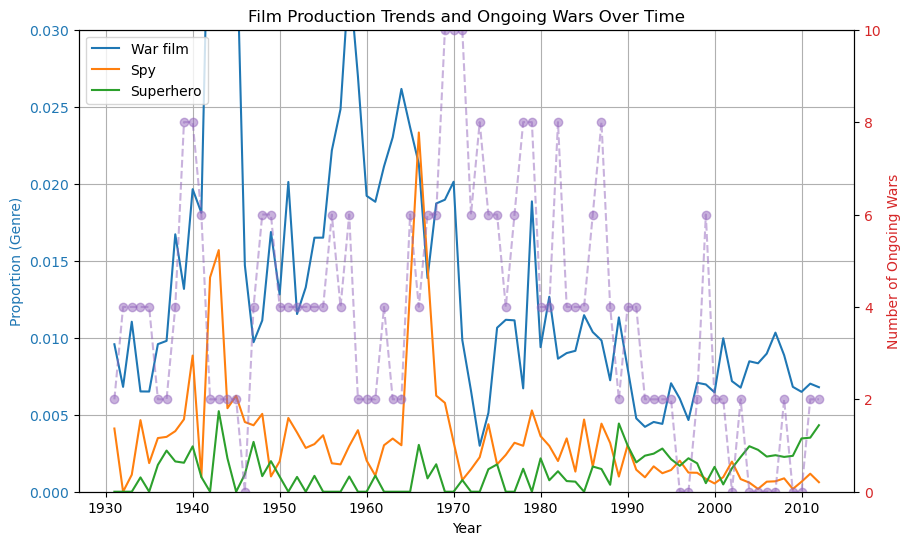

                   War Name  Mean Peak Year
0       Third Sino-Japanese            1940
1                 Iran-Iraq            1979
2                  Nomonhan            1940
3               Franco-Thai            1940
4               Changkufeng            1940
5                  Cold War            1958
6      Vietnam War, Phase 2            1964
7             First Kashmir            1945
8              Arab-Israeli            1947
9              World War II            1940
10            Russo-Finnish            1940
11  Second Laotian, Phase 2            1966
12           Second Kashmir            1963


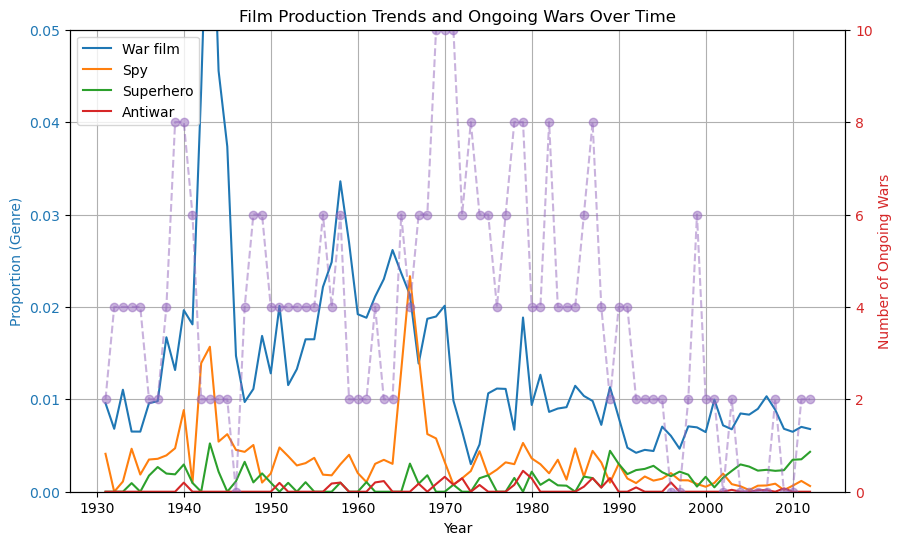

                    War Name  Mean Peak Year
0         Ugandian-Tanzanian            1976
1                  Iran-Iraq            1979
2        Communist Coalition            1968
3             Yom Kippur War            1971
4   Sino-Vietnamese Punitive            1979
5       Vietnamese-Cambodian            1976
6                   Cold War            1968
7       Vietnam War, Phase 2            1968
8             Azeri-Armenian            1992
9    Second Laotian, Phase 2            1968
10             Turco-Cypriot            1972
11     Bangladesh Liberation            1970
12              Badme Border            1997


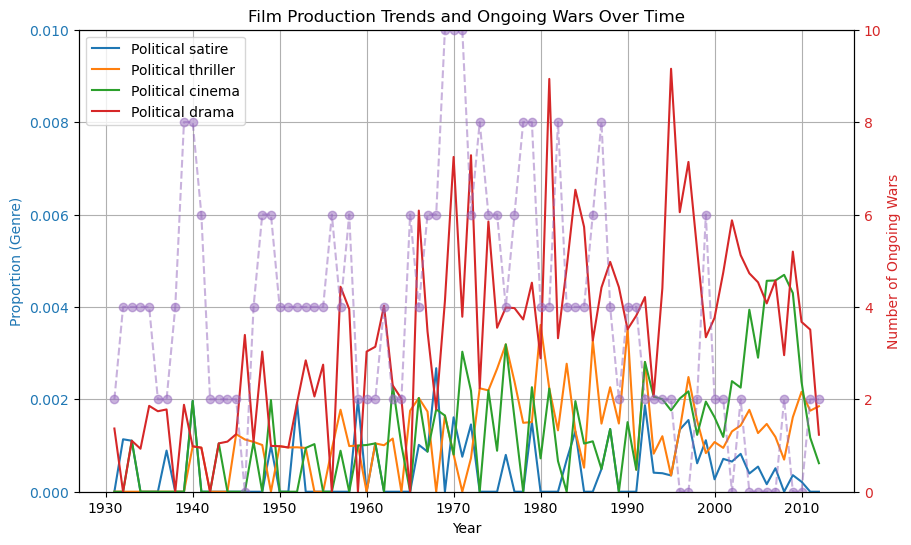

                      War Name  Mean Peak Year
0           Ugandian-Tanzanian            1977
1                Cenepa Valley            1993
2                    Iran-Iraq            1985
3          Communist Coalition            1971
4   Second Ogaden War, Phase 2            1975
5               Yom Kippur War            1973
6         Vietnamese-Cambodian            1975
7                     Cold War            1973
8         Vietnam War, Phase 2            1973
9                Turco-Cypriot            1973
10              Azeri-Armenian            1993
11     Second Laotian, Phase 2            1973
12    Sino-Vietnamese Punitive            1977
13                       Assam            1960
14             War over Angola            1973
15       Bangladesh Liberation            1971
16              Second Kashmir            1963


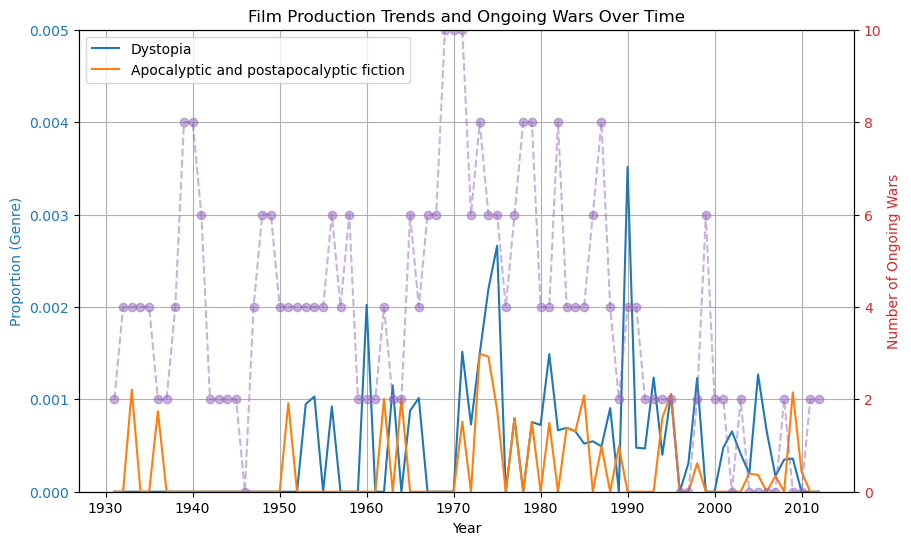

In [1277]:
def count_ongoing_wars(df_wars):
    years = pd.Series(range(df_wars['StartYear'].min(), df_wars['EndYear'].max() + 1), name="Year")
    ongoing_wars_count = []
    
    for year in years:
        ongoing_wars = df_wars[(df_wars['StartYear'] <= year) & (df_wars['EndYear'] >= year)]
        ongoing_wars_count.append(len(ongoing_wars))  # Store the count of ongoing wars for this year
    
    ongoing_wars_df = pd.DataFrame({'Year': years, 'Ongoing Wars': ongoing_wars_count})
    
    return ongoing_wars_df

def inspect_peaks_events(genre_list, ylim):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    peak_wars = []
    
    # Loop through genres and plot them on the same plot (Primary Y-Axis)
    for genre in genre_list:
        # Call the analyze_genre_wars function for the current genre, which now returns data
        genre_data = analyze_genre_wars(df_movies, df_wars, genre)
        
        # Plot each genre's data on the primary axes
        ax1.plot(genre_data[0], genre_data[1], label=f"{genre}")

        peak_wars.append(genre_data[2][["War Name", "Peak Year"]])

    ax1.set_title('Film Production Trends and Ongoing Wars Over Time')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Proportion (Genre)', color='tab:blue')
    ax1.set_ylim(0, ylim)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True)

    # Calculate the intersection of "War Name" across all genres
    intersection = set(peak_wars[0]['War Name'])  # Start with the "War Name" from the first genre
    
    for genre_data in peak_wars[1:]:
        intersection = intersection.intersection(set(genre_data['War Name']))

    # Filter each genre data to include only the intersected "War Name"
    filtered_peak_wars = []
    for genre_data in peak_wars:
        filtered_peak_wars.append(genre_data[genre_data['War Name'].isin(intersection)])

    # Step 1: Create a DataFrame to store the intersected "War Name" and the mean "Peak Year" values
    mean_values = []

    # Iterate through the filtered data frames and compute the mean for each "War Name"
    for war_name in intersection:
        # Collect Peak Year values for the intersecting War Name from each genre
        peak_years = [genre_data[genre_data['War Name'] == war_name]['Peak Year'].values[0] for genre_data in filtered_peak_wars]
        
        # Compute the mean for the Peak Year values for this War Name
        mean_peak_year = min(peak_years)
        
        # Store the results (War Name and Mean Peak Year)
        mean_values.append({"War Name": war_name, "Mean Peak Year": mean_peak_year})

    # Convert the mean values to a DataFrame
    mean_df = pd.DataFrame(mean_values)

    # Add vertical lines for each mean peak year
    #for _, row in mean_df.iterrows():
        #ax1.axvline(x=row['Mean Peak Year'], color='red', linestyle='--', label=f"Mean Peak Year for {row['War Name']}")

    # Print the DataFrame with the mean values for inspection
    print(mean_df)

    # Create the secondary y-axis for ongoing wars
    ax2 = ax1.twinx()

    # Calculate ongoing wars per year
    ongoing_wars_df = count_ongoing_wars(df_wars)

    # Plot the number of ongoing wars on the secondary y-axis
    ax2.plot(ongoing_wars_df['Year'], ongoing_wars_df['Ongoing Wars'], color='tab:purple', label='Ongoing Wars', linestyle='--', marker='o', alpha = 0.5)

    ax2.set_ylabel('Number of Ongoing Wars', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0, 10)

    # Add legends for both y-axes
    ax1.legend(loc='upper left')
    #ax2.legend(loc='upper right')

    # Display the plot
    plt.show()
    return mean_df
military_events = inspect_peaks_events(military_genres, 0.03)
mil_antiwar_peaks = inspect_peaks_events(military_and_antiwar, 0.05)
polit_peaks = inspect_peaks_events(reflecting_genres, 0.01)
dystop_peaks = inspect_peaks_events(dystopian_genres, 0.005)

In [1278]:
military_events = set(military_events['War Name'])
mil_antiwar_peaks = set(mil_antiwar_peaks['War Name'])
polit_peaks = set(polit_peaks['War Name'])
dystop_peaks = set(dystop_peaks['War Name'])

# Combine all sets into a list for easier iteration
war_name_sets = [military_events, mil_antiwar_peaks, polit_peaks, dystop_peaks]

# Use a dictionary to count occurrences of each war name across the DataFrames
from collections import Counter

war_name_counter = Counter()

# Count occurrences of each war name in the union of all sets
for war_set in war_name_sets:
    war_name_counter.update(war_set)

# Get the list of war names that appear in at least two DataFrames
at_least_two = [war for war, count in war_name_counter.items() if count >= 2]

print("War Names present in at least 2 dataframes:", at_least_two)
movies_released = {}
for warname in at_least_two:
    war = df_wars[df_wars["WarName"] == warname]
    starting = war["StartYear"].values[0]
    ending = war["EndYear"].values[0]
    releases = df_movies[(df_movies["Year"] >= starting) & (df_movies["Year"] <= ending)].shape[0]
    movies_released[warname] = releases
    
filtered_wars = {key: value for key, value in movies_released.items() if value >= 2000}
print(filtered_wars)

War Names present in at least 2 dataframes: ['Third Sino-Japanese', 'Iran-Iraq', 'Nomonhan', 'Franco-Thai', 'Changkufeng', 'Vietnam War, Phase 2', 'First Kashmir', 'Arab-Israeli', 'Cold War', 'World War II', 'Russo-Finnish', 'Second Laotian, Phase 2', 'Second Kashmir', 'Ugandian-Tanzanian', 'Communist Coalition', 'Yom Kippur War', 'Vietnamese-Cambodian', 'Turco-Cypriot', 'Azeri-Armenian', 'Sino-Vietnamese Punitive', 'Bangladesh Liberation']
{'Iran-Iraq': 4412, 'Vietnam War, Phase 2': 4246, 'Cold War': 18052, 'World War II': 2162, 'Second Laotian, Phase 2': 2384}


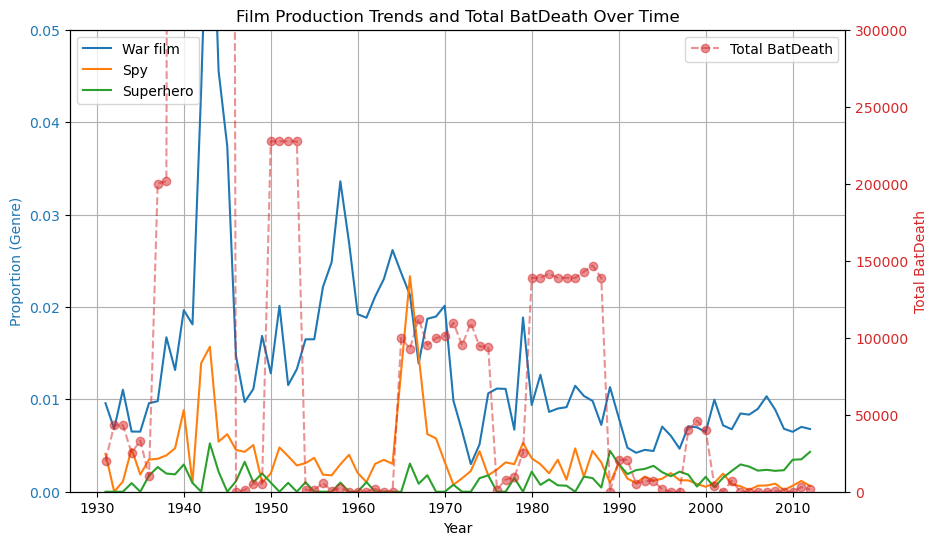

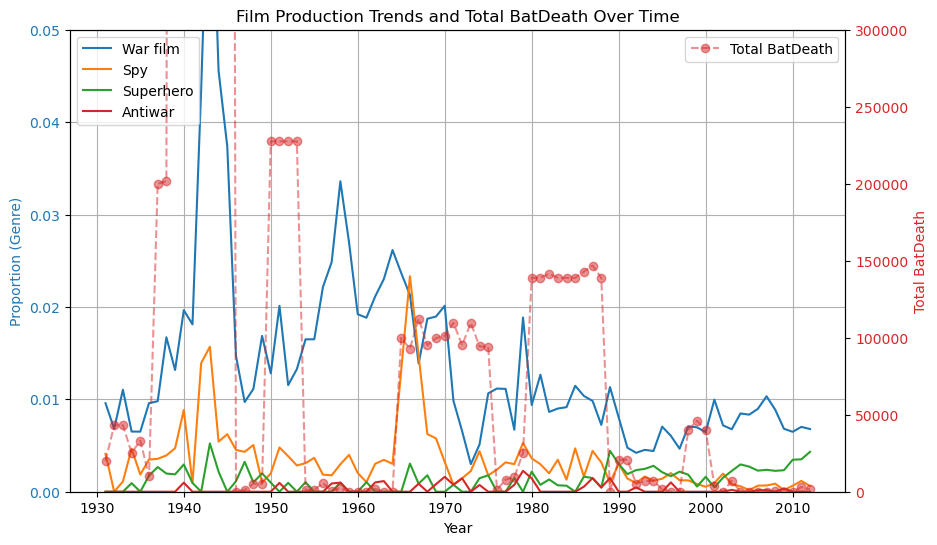

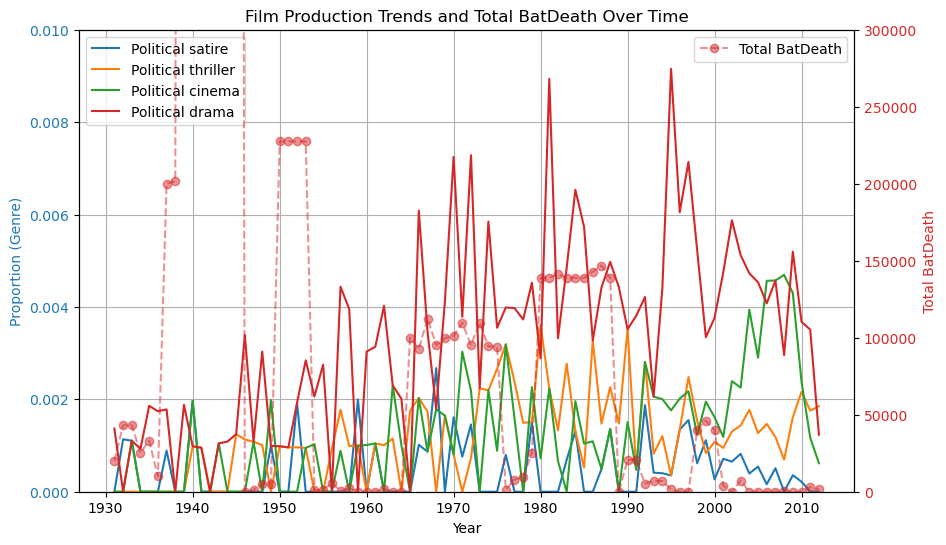

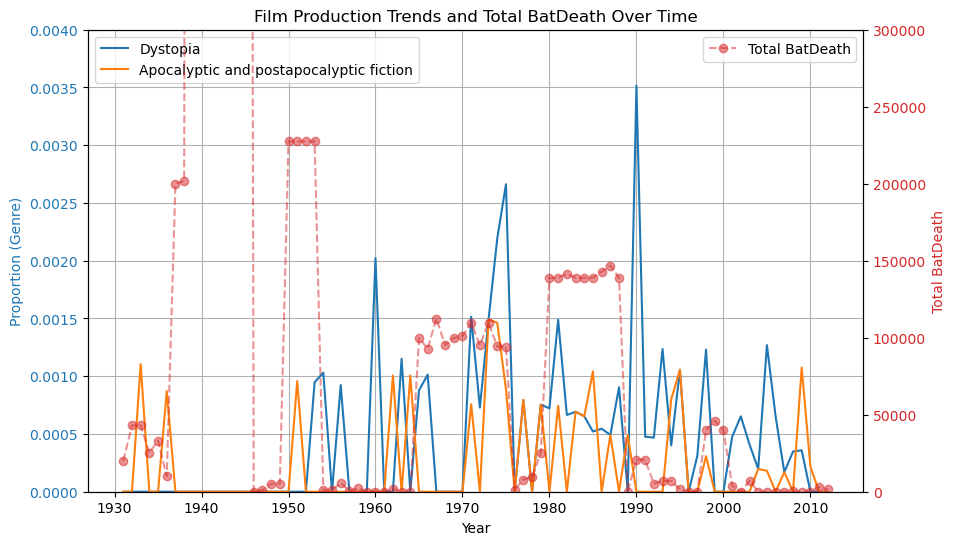

In [1279]:
def calc_bat_deaths():
    df_aggregated = df_wars.groupby(['WarName', 'StartYear', 'EndYear'], as_index=False)['BatDeath'].sum()
    df_aggregated['Duration'] = df_aggregated['EndYear'] - df_aggregated['StartYear'] + 1

    # 2. Expand the dataframe to have a row per year
    expanded_df = df_aggregated.loc[df_aggregated.index.repeat(df_aggregated['Duration'])].copy()

    # 3. Add a 'Year' column for each row
    expanded_df['Year'] = expanded_df.groupby(level=0).cumcount() + expanded_df['StartYear']

    # 4. Distribute BatDeath evenly across the war's years
    expanded_df['Count'] = expanded_df['BatDeath'] / expanded_df['Duration']

    # 5. Group by year and sum the yearly deaths
    yearly_deaths = expanded_df.groupby('Year')['Count'].sum().reset_index()

    # 6. Ensure all years from the earliest StartYear to the latest EndYear are included
    min_year = df_aggregated['StartYear'].min()
    max_year = df_aggregated['EndYear'].max()
    all_years = pd.DataFrame({'Year': range(min_year, max_year + 1)})

    # 7. Merge with the yearly_deaths dataframe and fill missing values with 0
    final_df = pd.merge(all_years, yearly_deaths, on='Year', how='left').fillna(0)
    return final_df

def inspect_peaks_events_with_batdeath(genre_list, ylim):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    peak_wars = []
    
    # Loop through genres and plot them on the same plot (Primary Y-Axis)
    for genre in genre_list:
        # Call the analyze_genre_wars function for the current genre, which now returns data
        genre_data = analyze_genre_wars(df_movies, df_wars, genre)
        
        # Plot each genre's data on the primary axes
        ax1.plot(genre_data[0], genre_data[1], label=f"{genre}")

    ax1.set_title('Film Production Trends and Total BatDeath Over Time')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Proportion (Genre)', color='tab:blue')
    ax1.set_ylim(0, ylim)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.grid(True)

    # Create the secondary y-axis for summed BatDeath
    ax2 = ax1.twinx()

    # Calculate the total BatDeath per year
    total_batdeath_df = calc_bat_deaths()

    # Plot the summed BatDeath on the secondary y-axis
    ax2.plot(total_batdeath_df['Year'], total_batdeath_df['Count'], color='tab:red', label='Total BatDeath', linestyle='--', marker='o', alpha=0.5)

    # Set the secondary y-axis label
    ax2.set_ylabel('Total BatDeath', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Set the limits for the secondary y-axis to start from 0
    ax2.set_ylim(0, 0.3*(10**6))  # Adding a small margin to the top

    # Add legends for both y-axes
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Display the plot
    plt.show()

inspect_peaks_events_with_batdeath(military_genres, 0.05)
inspect_peaks_events_with_batdeath(military_and_antiwar, 0.05)
inspect_peaks_events_with_batdeath(reflecting_genres, 0.01)
inspect_peaks_events_with_batdeath(dystopian_genres, 0.004)


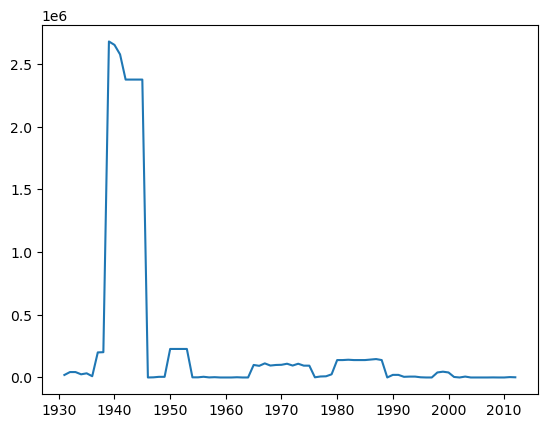

War Films and Battle Death Correlation:
 PearsonRResult(statistic=0.27240141105481724, pvalue=0.013292179344516724)
Spy Films and Battle Death Correlation:
 PearsonRResult(statistic=0.27393561393707544, pvalue=0.01276191257747632)
Superhero Films and Battle Death Correlation:
 PearsonRResult(statistic=-0.13520086619215188, pvalue=0.2258684534064674)
War and Spy Films and Battle Death Correlation:
 PearsonRResult(statistic=0.3173530124017836, pvalue=0.0036709699741463014)
War, Spy, and Superhero Films and Battle Death Correlation:
 PearsonRResult(statistic=0.23797969907505123, pvalue=0.03132272885680519)
Political Genres and Battle Death Correlation:
 PearsonRResult(statistic=-0.2622585981428041, pvalue=0.017302423898822368)
Family Films and Battle Death Correlation:
 PearsonRResult(statistic=-0.2489395417403822, pvalue=0.024116590485987494)


In [1280]:
def calc_bat_deaths():
    df_aggregated = df_wars.groupby(['WarName', 'StartYear', 'EndYear'], as_index=False)['BatDeath'].sum()
    df_aggregated['Duration'] = df_aggregated['EndYear'] - df_aggregated['StartYear'] + 1

    # 2. Expand the dataframe to have a row per year
    expanded_df = df_aggregated.loc[df_aggregated.index.repeat(df_aggregated['Duration'])].copy()

    # 3. Add a 'Year' column for each row
    expanded_df['Year'] = expanded_df.groupby(level=0).cumcount() + expanded_df['StartYear']

    # 4. Distribute BatDeath evenly across the war's years
    expanded_df['Count'] = expanded_df['BatDeath'] / expanded_df['Duration']

    # 5. Group by year and sum the yearly deaths
    yearly_deaths = expanded_df.groupby('Year')['Count'].sum().reset_index()

    # 6. Ensure all years from the earliest StartYear to the latest EndYear are included
    min_year = df_aggregated['StartYear'].min()
    max_year = df_aggregated['EndYear'].max()
    all_years = pd.DataFrame({'Year': range(min_year, max_year + 1)})

    # 7. Merge with the yearly_deaths dataframe and fill missing values with 0
    final_df = pd.merge(all_years, yearly_deaths, on='Year', how='left').fillna(0)
    return final_df

bat_deaths_yearly = calc_bat_deaths()

plt.plot(bat_deaths_yearly["Year"], bat_deaths_yearly["Count"])
plt.show()

def correlation_genre_batdeath(genredf, otherdf):
    otherdf_filtered = otherdf[otherdf["Year"] <= 2012]
    genredf_filtered = genredf[(genredf["Year"] >= 1931) & (genredf["Year"] <= 2012)]

    correlation = stats.pearsonr(genredf_filtered["Count"], otherdf_filtered["Count"])
    return correlation


war_films_yearly = count_genre_over_years(df_movies, "War film")
print("War Films and Battle Death Correlation:\n", correlation_genre_batdeath(war_films_yearly, bat_deaths_yearly))

spy_films_yearly = count_genre_over_years(df_movies, "Spy")
print("Spy Films and Battle Death Correlation:\n", correlation_genre_batdeath(spy_films_yearly, bat_deaths_yearly))

superhero_films_yearly = count_genre_over_years(df_movies, "Superhero")
print("Superhero Films and Battle Death Correlation:\n", correlation_genre_batdeath(superhero_films_yearly, bat_deaths_yearly))

'''
Correlation for a list of war-related movies and battle deaths
'''
warandspy = war_films_yearly.merge(
    spy_films_yearly, on="Year", how="inner", suffixes=("_War", "_Spy")
)
warandspy["Count"] = warandspy["Count_War"] + warandspy["Count_Spy"]

# Merge war-spy combination with superhero films yearly counts
warspysuperhero = warandspy.merge(
    superhero_films_yearly, on="Year", how="inner"
)

# Use the column name 'Count' from superhero_films_yearly (it remains unchanged after merge)
warspysuperhero["Count"] = (
    warspysuperhero["Count_x"] + warspysuperhero["Count_y"]
)

print("War and Spy Films and Battle Death Correlation:\n", correlation_genre_batdeath(warandspy, bat_deaths_yearly))
print("War, Spy, and Superhero Films and Battle Death Correlation:\n", correlation_genre_batdeath(warspysuperhero, bat_deaths_yearly))

'''
Correlation for all the political genres
'''
reflecting_genres_yearly = pd.DataFrame()

for genre in reflecting_genres:
    # Calculate yearly counts for each genre
    genre_yearly = count_genre_over_years(df_movies, genre)
    
    if reflecting_genres_yearly.empty:
        reflecting_genres_yearly = genre_yearly.rename(columns={"Count": f"Count_{genre}"})
    else:
        reflecting_genres_yearly = reflecting_genres_yearly.merge(
            genre_yearly.rename(columns={"Count": f"Count_{genre}"}), 
            on="Year", 
            how="outer"
        )

# Step 2: Fill missing values with 0 and calculate the total count across all genres
reflecting_genres_yearly = reflecting_genres_yearly.fillna(0)
reflecting_genres_yearly["Count"] = reflecting_genres_yearly[
    [f"Count_{genre}" for genre in reflecting_genres]
].sum(axis=1)

# Step 3: Use your existing correlation_genre_batdeath function to calculate the correlation
correlation = correlation_genre_batdeath(reflecting_genres_yearly, bat_deaths_yearly)

print("Political Genres and Battle Death Correlation:\n", correlation)

family_films_yearly = count_genre_over_years(df_movies, "Family Film")
print("Family Films and Battle Death Correlation:\n", correlation_genre_batdeath(family_films_yearly, bat_deaths_yearly))


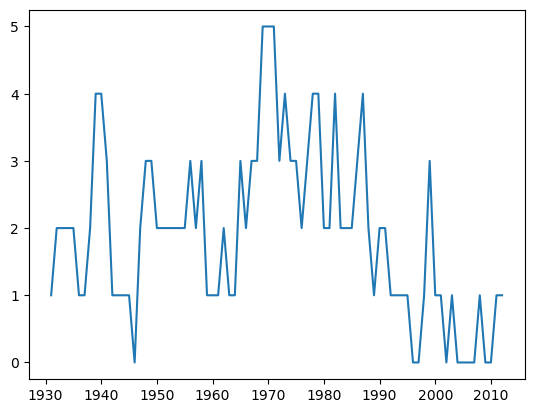

Romance Film and Number of Wars Correlation:
 PearsonRResult(statistic=-0.5462659444694848, pvalue=1.1050272342839604e-07)
Romance Film and Number of Wars Correlation 1950-2000:
 PearsonRResult(statistic=-0.39255317843252996, pvalue=0.004382406568502876)
War film and Number of Wars Correlation:
 PearsonRResult(statistic=-0.38579387064742987, pvalue=0.00034424103597972713)
War film and Number of Wars Correlation 1950-2000:
 PearsonRResult(statistic=-0.031274453305273925, pvalue=0.8275377820369273)
Spy and Number of Wars Correlation:
 PearsonRResult(statistic=0.09627168852556904, pvalue=0.38957153399953154)
Spy and Number of Wars Correlation 1950-2000:
 PearsonRResult(statistic=0.13307489494265987, pvalue=0.35188766124055093)
Superhero and Number of Wars Correlation:
 PearsonRResult(statistic=-0.5624595559041975, pvalue=3.812732446312208e-08)
Superhero and Number of Wars Correlation 1950-2000:
 PearsonRResult(statistic=-0.46210621847572037, pvalue=0.0006408169243653027)
Family Film and N

In [1281]:
def wars_per_year():
    df_agg = df_wars.groupby(['WarName', 'StartYear', 'EndYear'], as_index=False)['BatDeath'].sum()
    min_year = df_agg['StartYear'].min()
    max_year = df_agg['EndYear'].max()

    # 2. Create a list of all years in the range
    all_years = range(min_year, max_year + 1)

    # 3. For each year, count how many wars were ongoing
    ongoing_counts = []
    for year in all_years:
        # Count how many wars have StartYear <= year <= EndYear
        count = ((df_agg['StartYear'] <= year) & (df_agg['EndYear'] >= year)).sum()
        ongoing_counts.append(count)

    # 4. Create a dataframe of results
    ongoing_df = pd.DataFrame({
        'Year': all_years,
        'Count': ongoing_counts
    })

    return ongoing_df

wars_yearly = wars_per_year()
plt.plot(wars_yearly["Year"], wars_yearly["Count"])
plt.show()

wars_yearly_cut = wars_yearly[(wars_yearly["Year"] >= 1950) & (wars_yearly["Year"] <= 2000)]

def correlation_check(genre):
    films = count_genre_over_years(df_movies, genre)
    print(f"{genre} and Number of Wars Correlation:\n", correlation_genre_batdeath(films, wars_yearly))
    films_cut = films[(films["Year"] >= 1950) & (films["Year"] <= 2000)]
    print(f"{genre} and Number of Wars Correlation 1950-2000:\n", correlation_genre_batdeath(films_cut, wars_yearly_cut))

correlation_check("Romance Film")
correlation_check("War film")
correlation_check("Spy")
correlation_check("Superhero")
correlation_check("Family Film")
correlation_check("Romance Film")
correlation_check("Romantic comedy")
correlation_check("Comedy")
correlation_check("Fantasy")
correlation_check("Thriller")
correlation_check("Horror")
correlation_check("Drama")
correlation_check("Social issues")
correlation_check("Antiwar")
correlation_check("Disaster")

print("War and Spy correlation:\n", correlation_genre_batdeath(warandspy, wars_yearly))
superhero_cut = superhero_films_yearly[(superhero_films_yearly["Year"] >= 1950) & (superhero_films_yearly["Year"] <= 2000)]
print("War and Spy Films and Number of Wars Correlation: 1950-2000\n", correlation_genre_batdeath(superhero_cut, wars_yearly_cut))

print("War, Spy, and Superhero correlation:\n", correlation_genre_batdeath(warspysuperhero, wars_yearly))
warandspy_cut = warandspy[(warandspy["Year"] >= 1950) & (warandspy["Year"] <= 2000)]
print("War, Spy, and Superhero Films and Number of Wars Correlation: 1950-2000\n", correlation_genre_batdeath(warandspy_cut, wars_yearly_cut))

print("Political genres and Number of Wars Correlation:\n", correlation_genre_batdeath(reflecting_genres_yearly, wars_yearly))
reflecting_genres_yearly_cut = reflecting_genres_yearly[(reflecting_genres_yearly["Year"] >= 1950) & (reflecting_genres_yearly["Year"] <= 2000)]
print("Political genres and Number of Wars Correlation: 1950-2000\n", correlation_genre_batdeath(reflecting_genres_yearly_cut, wars_yearly_cut))


    Year       Revenue
0   1931  5.750000e+05
1   1932  7.320000e+05
2   1933  0.000000e+00
3   1934  5.830000e+05
4   1935  0.000000e+00
..   ...           ...
77  2008  3.013596e+09
78  2009  1.652455e+09
79  2010  2.633496e+08
80  2011  6.836398e+08
81  2012  9.975275e+07

[82 rows x 2 columns]


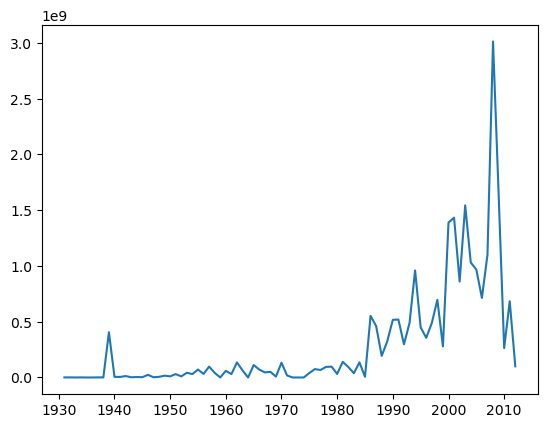

In [1282]:
#print(df_movies["Revenue"].dropna())
#print(df_movies["Revenue"].shape[0])
# war_films_revenue = df_movies[df_movies["Genres"] == "War films"]
# yearly_revenue = df_movies.groupby("Year")["Revenue"].sum().reset_index()
# yearly_revenue = yearly_revenue[yearly_revenue["Year"] >= 1970]
# print(yearly_revenue)
# plt.plot(yearly_revenue["Year"], yearly_revenue["Revenue"])

df_movies['Genres'] = df_movies['Genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Filter for "War film" in the Genres list
war_films = df_movies[df_movies['Genres'].apply(lambda genres: 'War film' in genres)]

# Group by Year and sum up the Revenue
war_films_revenue_by_year = war_films.groupby('Year')['Revenue'].sum().reset_index()

print(war_films_revenue_by_year)
plt.plot(war_films_revenue_by_year["Year"], war_films_revenue_by_year["Revenue"])


In [1283]:
wars_inspect = []
chosen_wars = pd.DataFrame()
for k, v in filtered_wars.items():
    wars_inspect.append(k)
    thewar = df_wars[df_wars["WarName"] == k]
    chosen_wars = pd.concat([chosen_wars, thewar], ignore_index=True)
chosen_wars = chosen_wars[~chosen_wars["WarName"].duplicated(keep='first')]
print(chosen_wars)

                   WarName  Side  StartYear  EndYear  \
0                Iran-Iraq     1       1980     1988   
2     Vietnam War, Phase 2     1       1965     1975   
4                 Cold War     1       1947     1991   
6             World War II     1       1939     1945   
8  Second Laotian, Phase 2     1       1968     1973   

                                           StateName    BatDeath  
0                                           ['Iran']    750000.0  
2                                        ['Vietnam']    700000.0  
4                          ['United States America']         0.0  
6  ['Belgium', 'Yugoslavia', 'Norway', 'Canada', ...  10717907.0  
8                                        ['Vietnam']      2250.0  


Analyzing the first War (Iran-Iraq War)

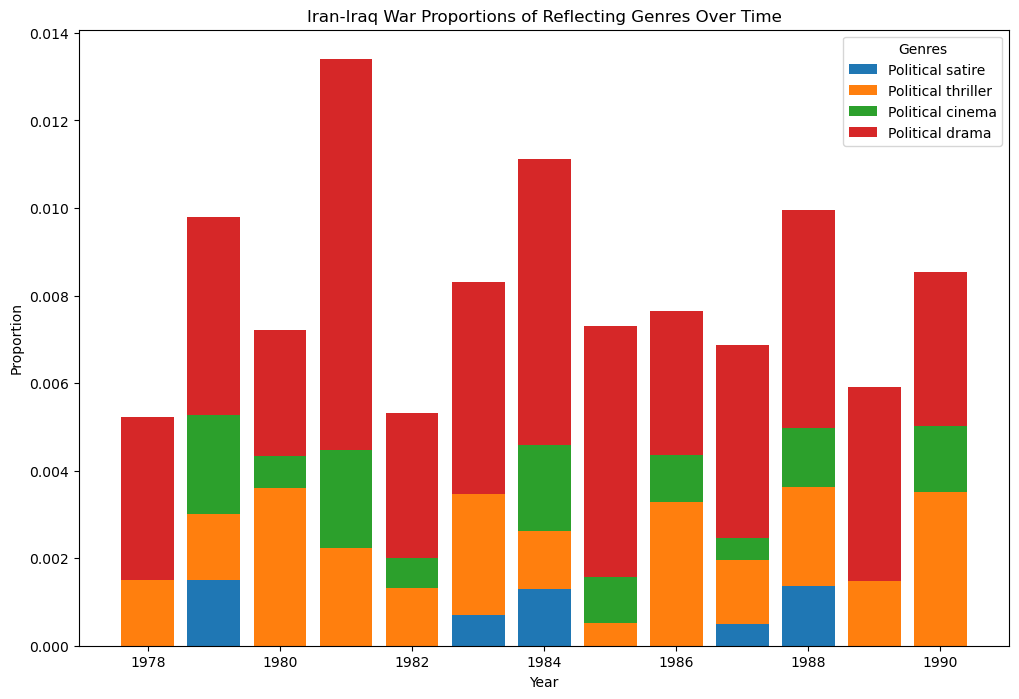

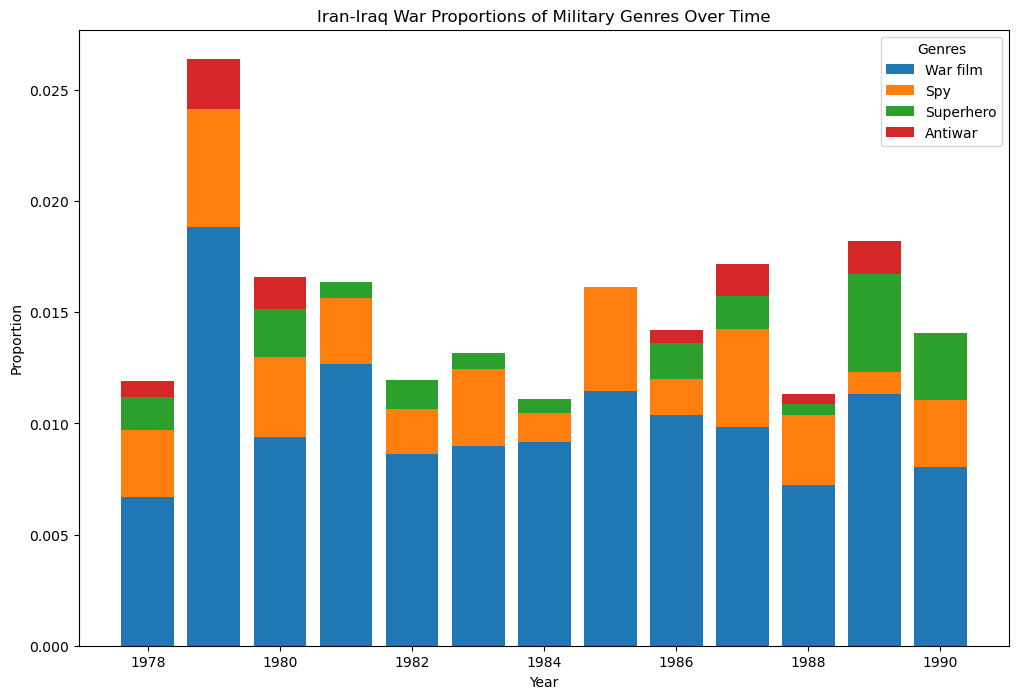

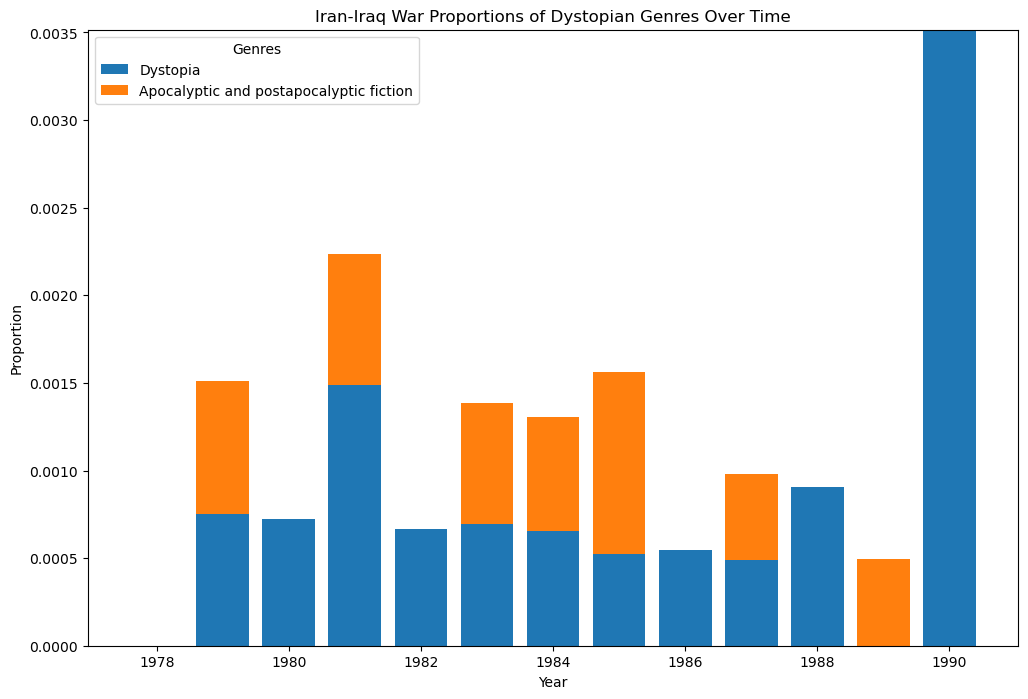

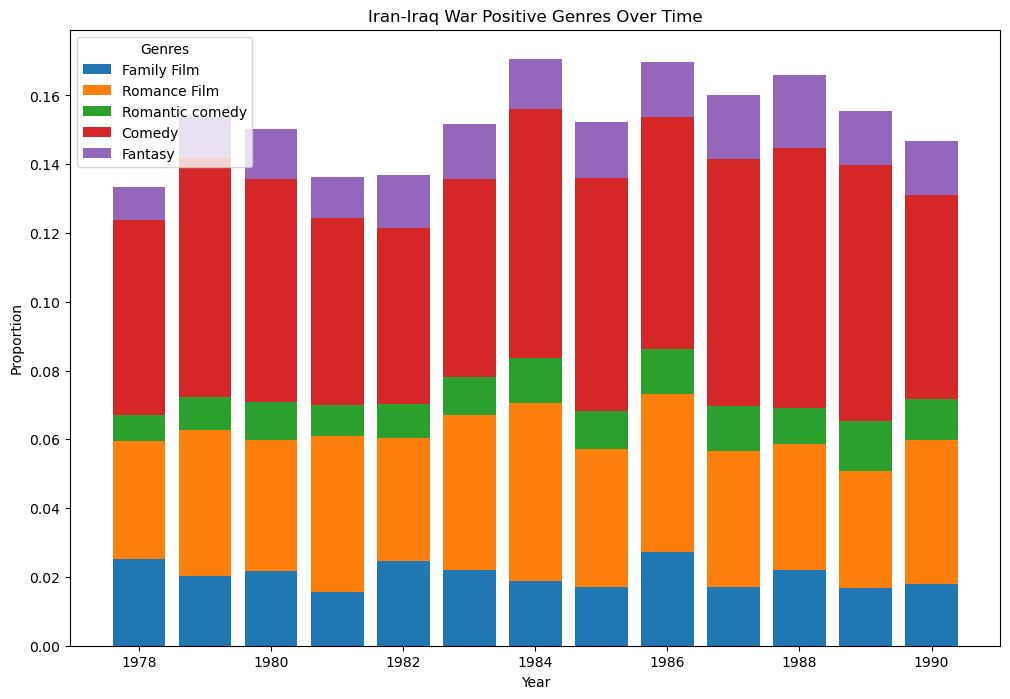

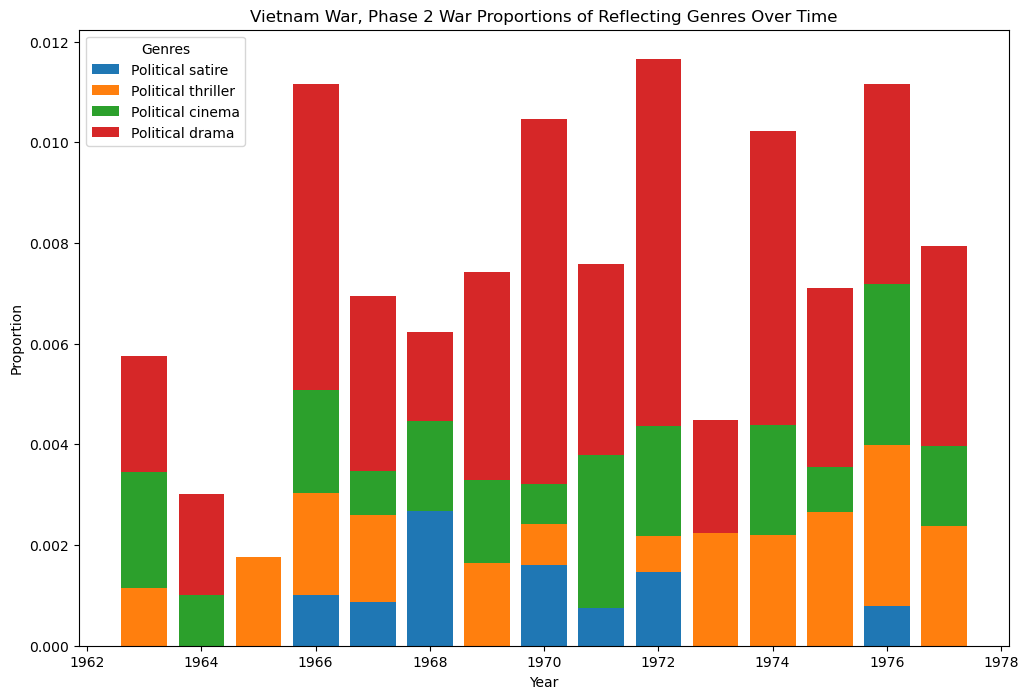

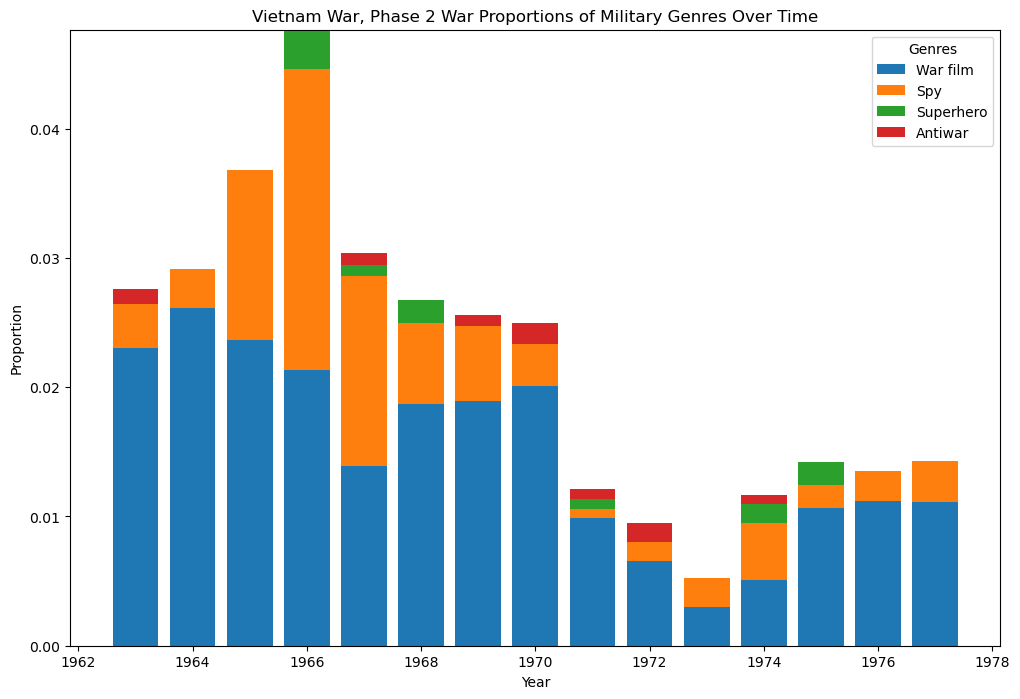

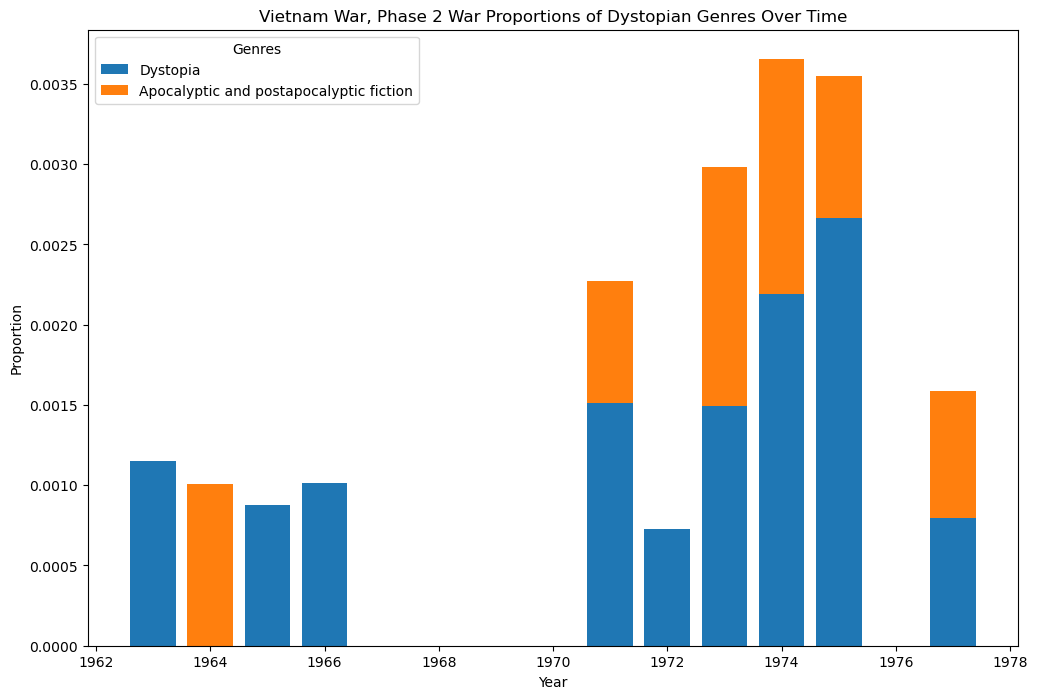

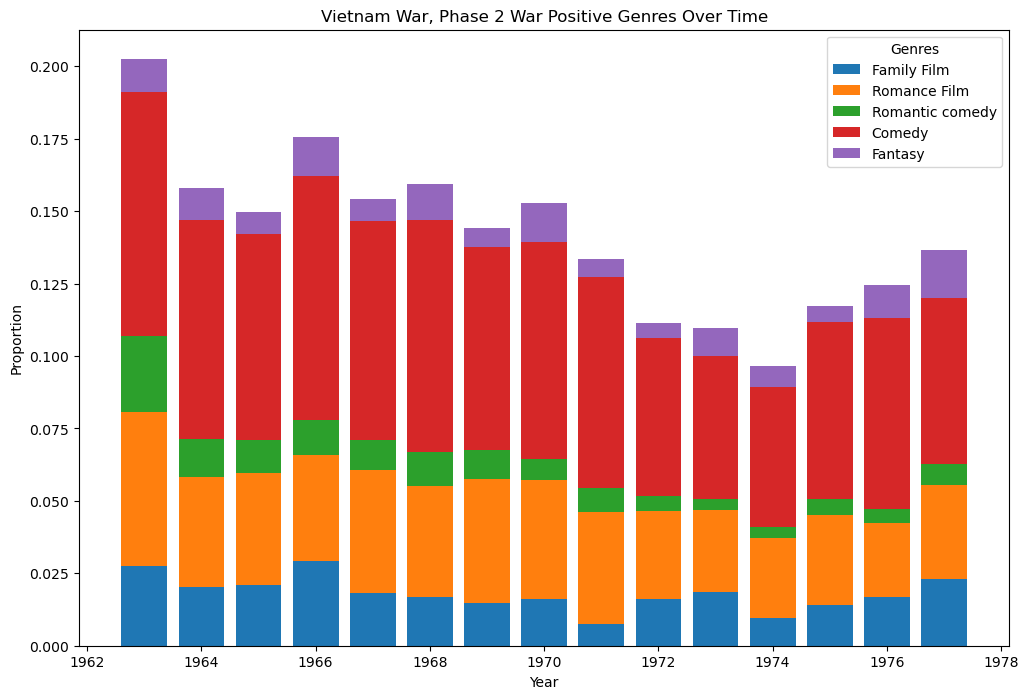

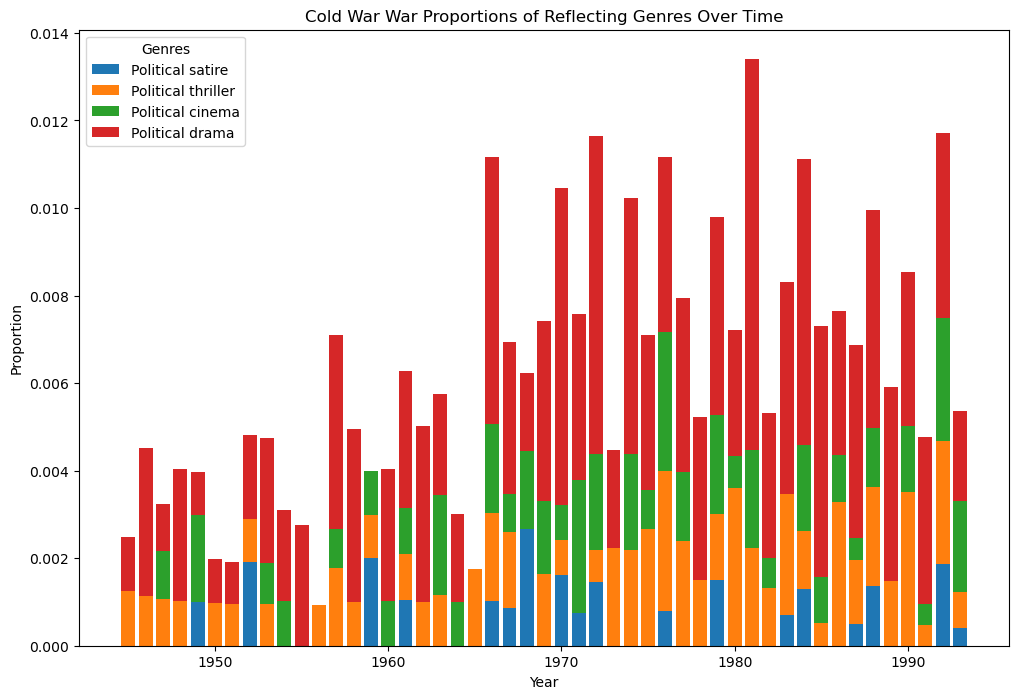

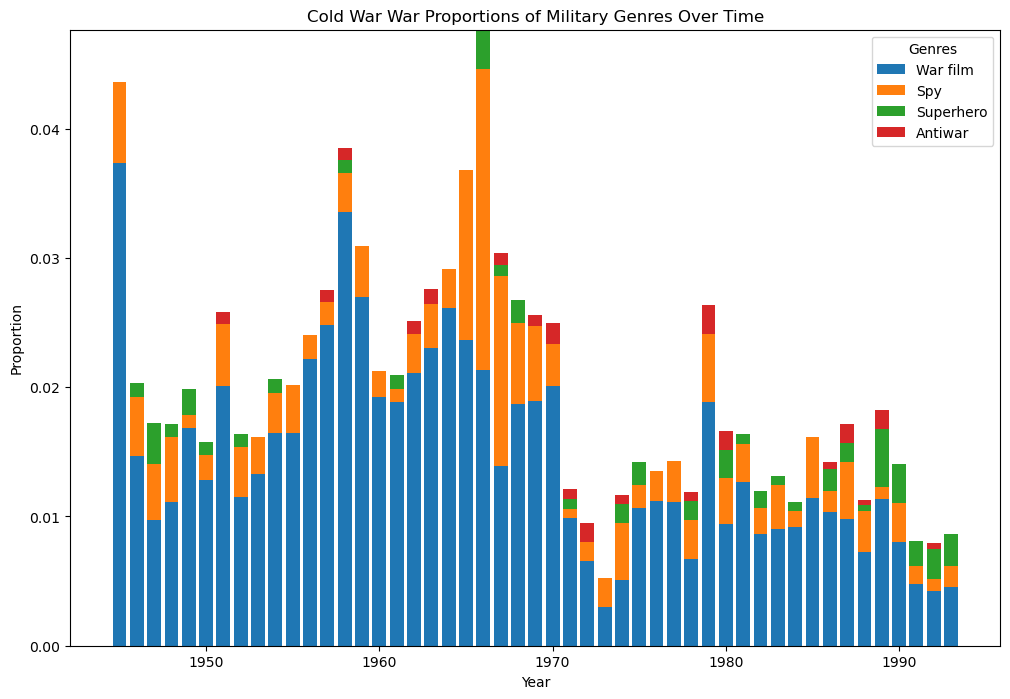

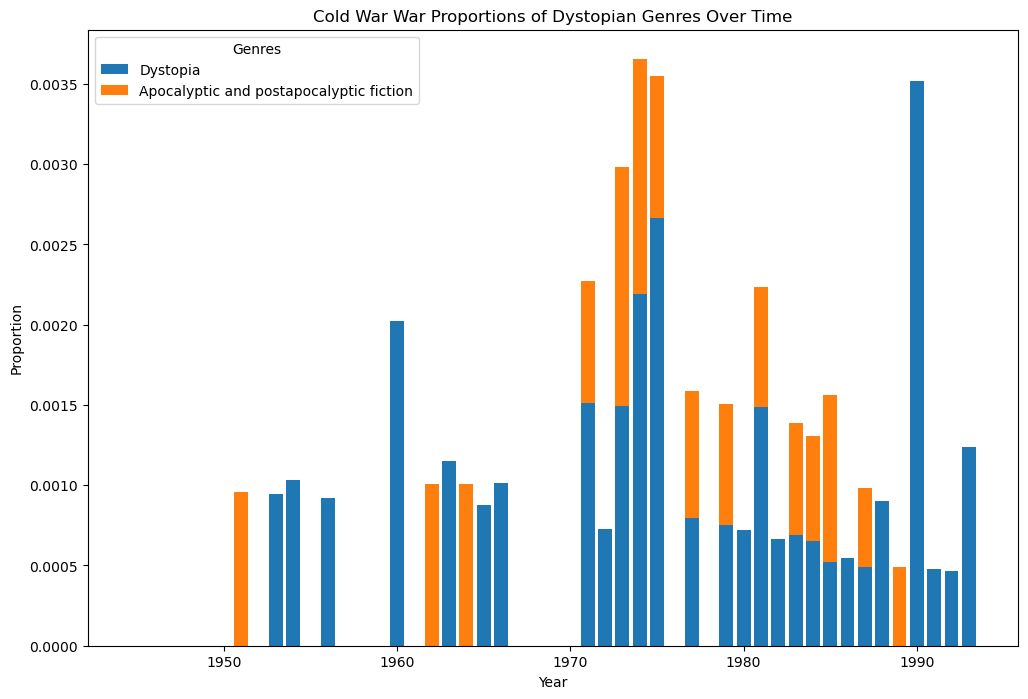

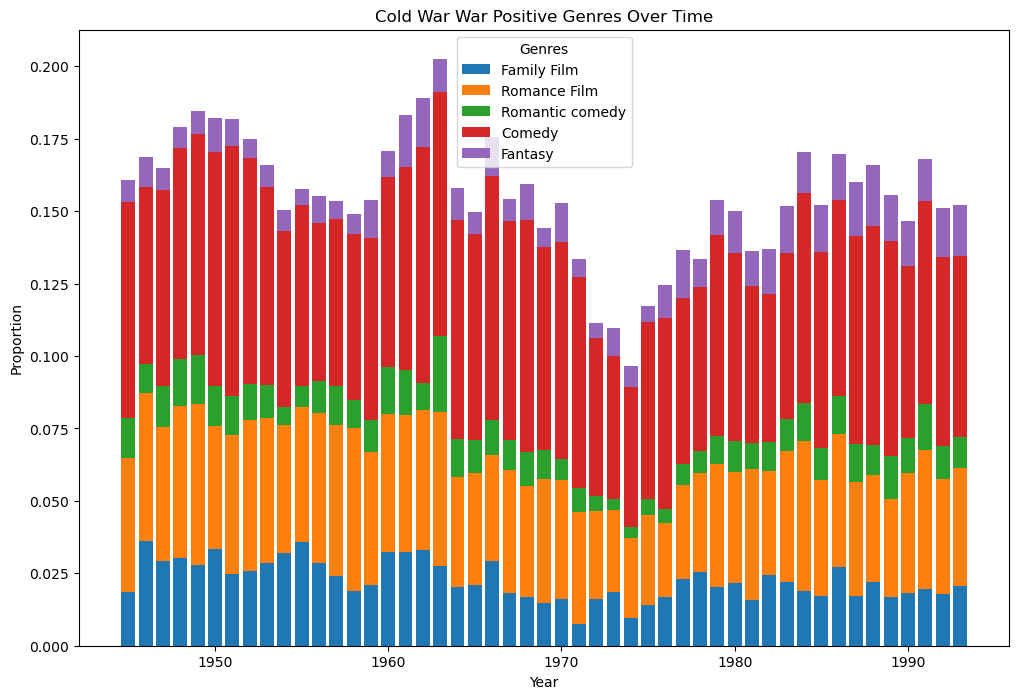

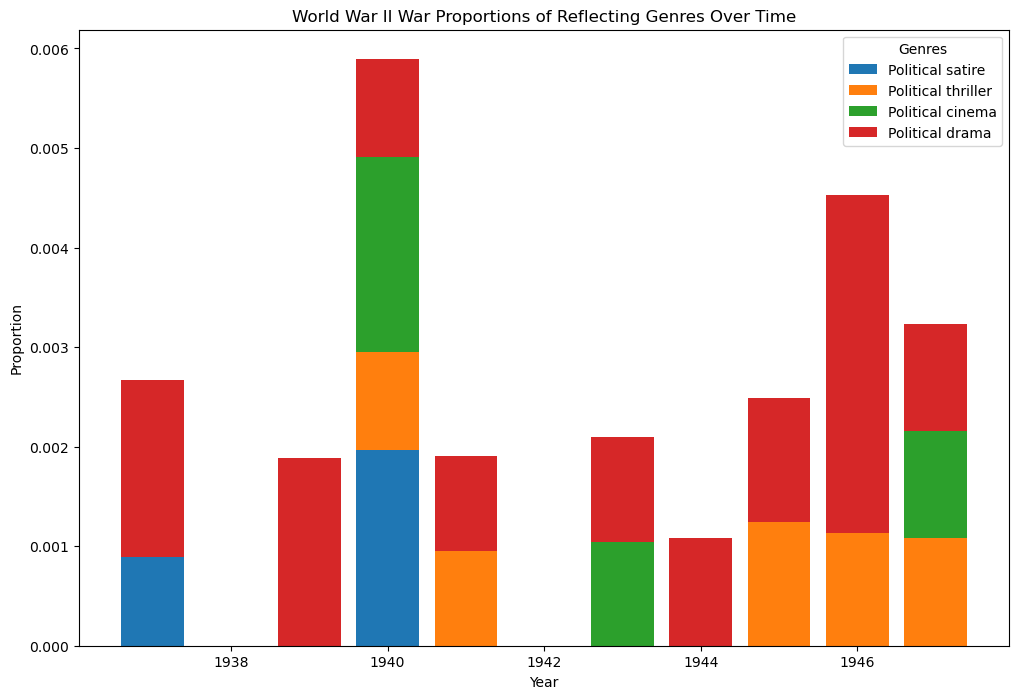

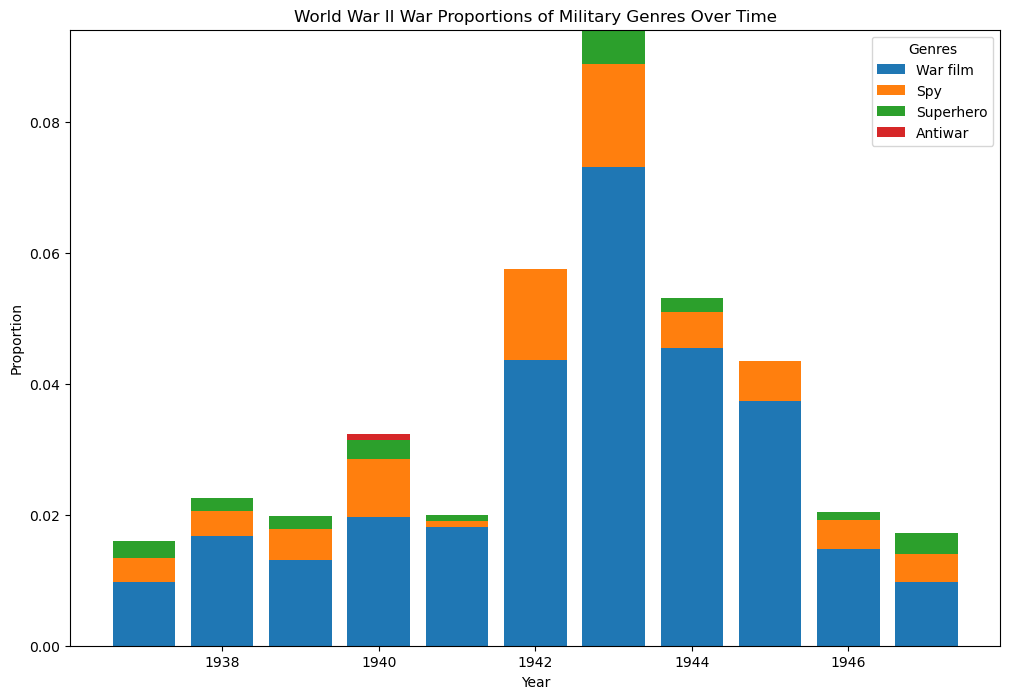

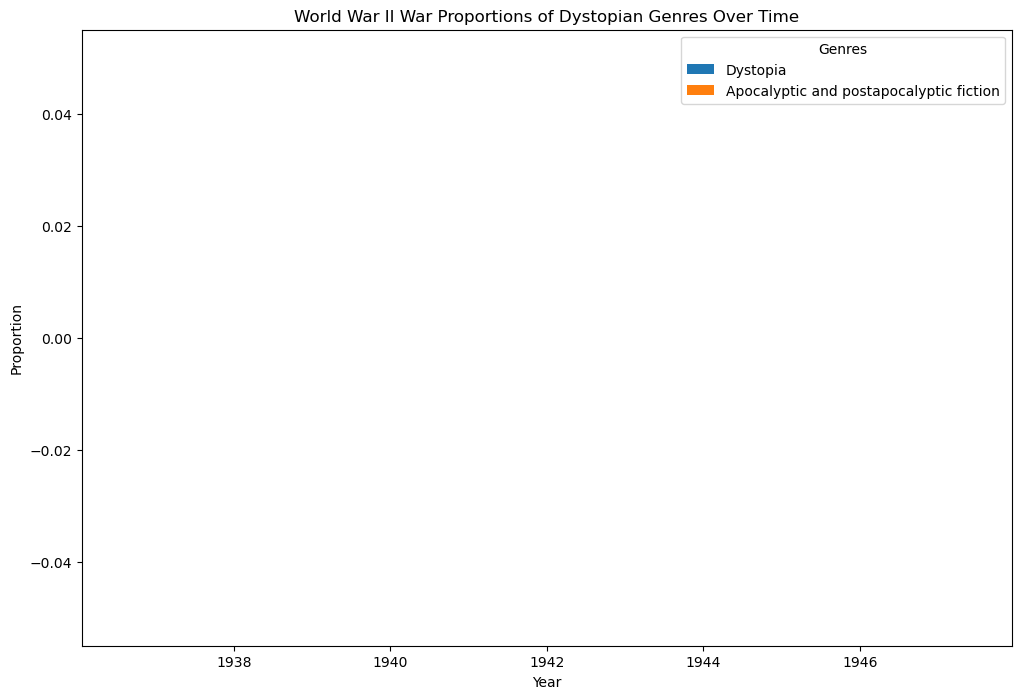

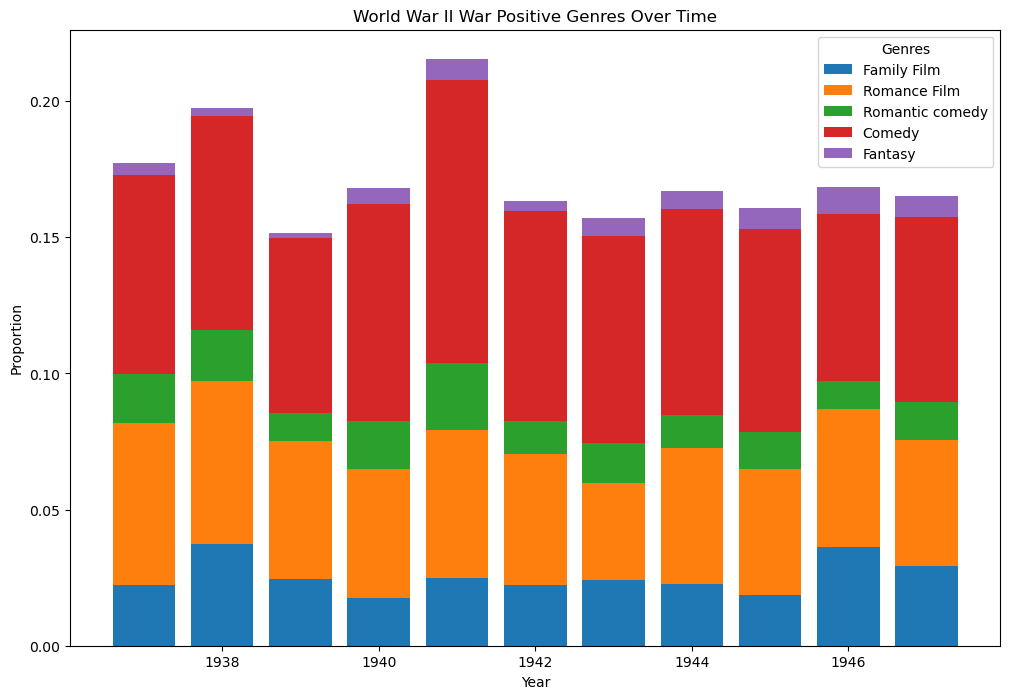

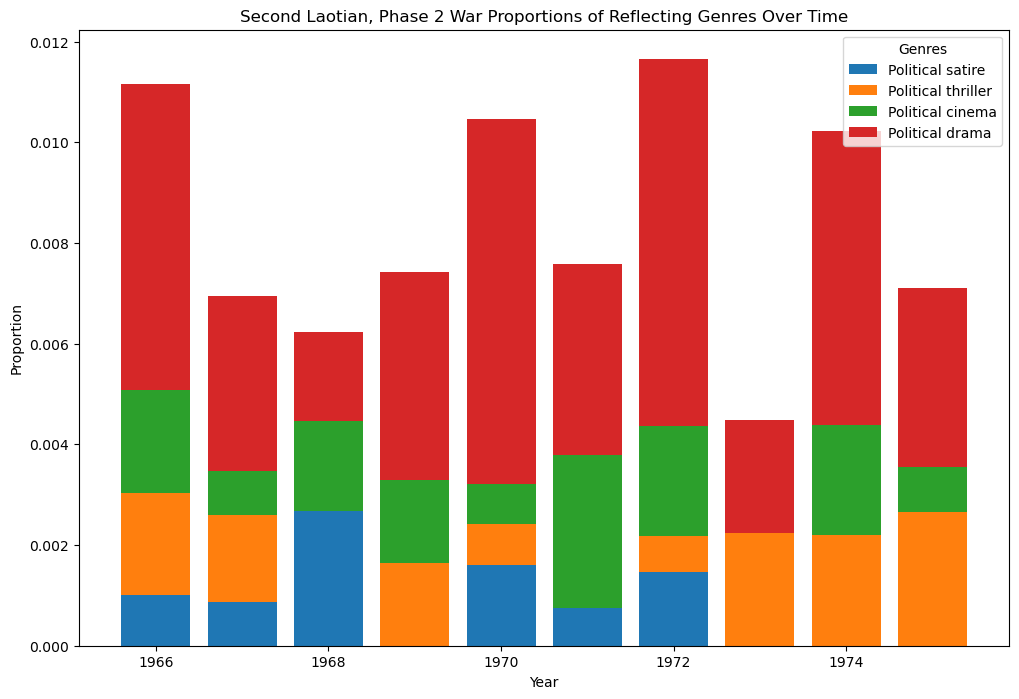

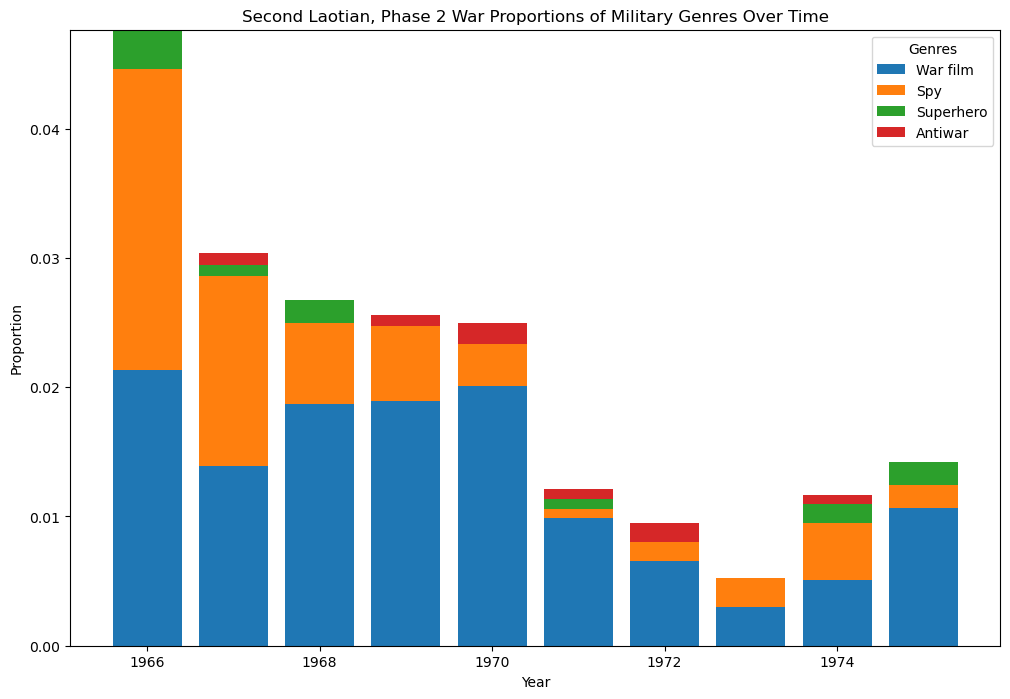

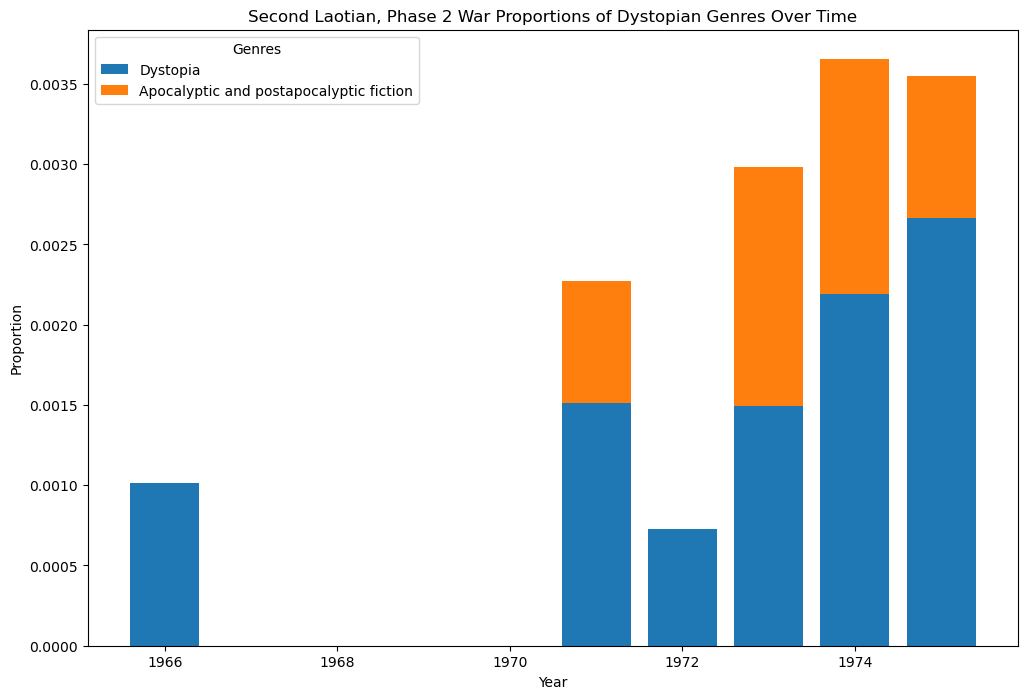

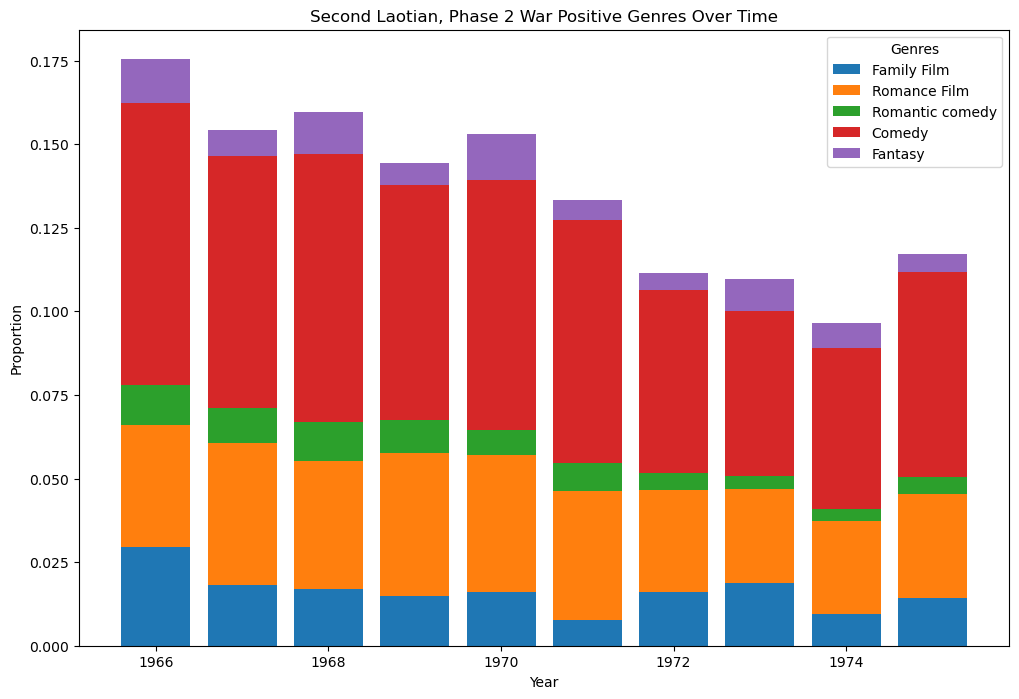

In [ ]:
def war_analysis(df_movies, init_year, fin_year, war_name):
    def stacked_bar_plot_by_genres(df_movies, genre_list, init_year, fin_year, title="Stacked Bar Plot of Proportions"):
        """
        Generates a stacked bar plot for the proportions of movies by the given list of genres over time.

        Parameters:
            df_movies (DataFrame): DataFrame containing movie data with "Year" and "Genres" columns.
            genre_list (list): List of genres to include in the plot.
            init_year (int): Starting year for the plot.
            fin_year (int): Ending year for the plot.
            title (str): Title of the plot (default: "Stacked Bar Plot of Proportions").

        Returns:
            None
        """
        # Initialize a DataFrame to hold proportions for each genre by year
        stacked_data = pd.DataFrame()

        for genre in genre_list:
            # Get proportions for each genre using count_genre_proportion function
            films_genre = count_genre_proportion(df_movies, genre)
            # Filter by year range
            films_genre = films_genre[(films_genre["Year"] >= init_year) & (films_genre["Year"] <= fin_year)]
            # Add the genre's data to the stacked_data DataFrame
            stacked_data[genre] = films_genre.set_index("Year")["Proportion"]

        # Fill missing values with 0 for years where a genre has no movies
        stacked_data = stacked_data.fillna(0)

        # Create the stacked bar plot
        plt.figure(figsize=(12, 8))
        bottom = np.zeros(len(stacked_data))  # Initialize the bottom for stacking

        for genre in genre_list:
            plt.bar(stacked_data.index, stacked_data[genre], label=genre, bottom=bottom)
            bottom += stacked_data[genre]  # Update the bottom for stacking

        # Add labels, legend, and title
        plt.xlabel("Year")
        plt.ylabel("Proportion")
        plt.title(title)
        plt.legend(title="Genres")
        plt.show()

    stacked_bar_plot_by_genres(
        df_movies=df_movies,
        genre_list=reflecting_genres,
        init_year=init_year,
        fin_year=fin_year,
        title=f"{war_name} War Proportions of Political Genres Over Time"
    )

    stacked_bar_plot_by_genres(
        df_movies=df_movies,
        genre_list=military_and_antiwar,
        init_year=init_year,
        fin_year=fin_year,
        title=f"{war_name} War Proportions of Military Genres Over Time"
    )
    stacked_bar_plot_by_genres(
        df_movies=df_movies,
        genre_list=dystopian_genres,
        init_year=init_year,
        fin_year=fin_year,
        title=f"{war_name} War Proportions of Dystopian Genres Over Time"
    )
    positive_genres = ["Family Film", "Romance Film", "Romantic comedy", "Comedy", "Fantasy"]
    stacked_bar_plot_by_genres(
        df_movies=df_movies,
        genre_list=positive_genres,
        init_year=init_year,
        fin_year=fin_year,
        title=f"{war_name} War Positive Genres Over Time"
    )

def pick_years(chosen_wars, i):
    startyear = chosen_wars.iloc[i]["StartYear"]
    endyear = chosen_wars.iloc[i]["EndYear"]
    war_name = chosen_wars.iloc[i]["WarName"]
    init_year = startyear - 2
    fin_year = endyear + 2
    return init_year, fin_year

for i in range(len(chosen_wars)):
    start, end = pick_years(chosen_wars, i)
    war_analysis(df_movies, start, end, chosen_wars.iloc[i]["WarName"])